All import statements are here

In [318]:
import re
import nltk
import time 
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
import random
import scipy.spatial.distance as distance
import sklearn.metrics.pairwise as sk_dist
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import ShuffleSplit

Block for Kaggle utility

In [319]:
#!/usr/bin/env python

class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review, "html.parser").get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.decode('utf8').strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, \
                  remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences

The following block reads and cleans the train data file

In [320]:
train = pd.read_csv("./Data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("./Data/testData.tsv", header=0, delimiter="\t", quoting=3 )

nltk.download(['stopwords'])

clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list
for i in range( 0, len(train["review"])):
    clean_train_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(train["review"][i], True)))

# ****** Create a bag of words from the training set
# Initialize the "CountVectorizer" object, aka bag of words.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,stop_words = None,max_features = 5000)
print ("Cleaned training data, created the bag of words...\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaned training data, created the bag of words...



Function to calculate the 3 remaining feature matrices from X_counts

In [321]:
def calc_X_matrices(X_counts, train_set, istestset=False):
    # calculating X_binary- modifies  X_counts  so that all elements are either 0 or 1
    X_binary = X_counts
    X_binary[X_counts > 0] = 1
    
    # calculating X_tfidf- modifies  X_counts  by applying the sklearn tfidf vectorizer
    transformer = TfidfTransformer(smooth_idf=False)
    X_tfidf = transformer.fit_transform(X_counts)
    
    #we can only calculate binary_imbalance for train data, we dont have labels for test data
    if istestset==False:
        # calculating X_binary_imbalance- deletes 75% of the rows corresponding to sentiment=1 from x_counts
        indices = np.where(train['sentiment'] == 1)[0]  # indices of rows, having sentiment=1, or column=1
        random.seed(0)

        # number of indices with sentiment=1, might not be divisible by 4, hence using int()
        rows_to_drop = random.sample(range(0, len(indices)), int(3 * len(indices) / 4))
        X_binary_imbalance = np.delete(X_counts, rows_to_drop, 0)
        train_set_imbalance=np.delete(np.array(train_set), rows_to_drop, 0)
        train_df_imbalance=train_set.drop(train_set.index[rows_to_drop])
        #also store the corresponding targets for training
    else:
        #for test data, we should be using only X_binary, so return None for X_binary_imbalance
        X_binary_imbalance=None
        train_set_imbalance=None
        train_df_imbalance=None
    return X_binary,X_tfidf,X_binary_imbalance, train_set_imbalance, train_df_imbalance

In [322]:
#calculating X_counts- entries contain the raw word counts
#calculating X_counts outside function, since transform is different for test and train data
X_counts = vectorizer.fit_transform(clean_train_reviews)
X_counts = X_counts.toarray()

X_binary, X_tfidf, X_binary_imbalance,train_set_imbalance, train_df_imbalance =calc_X_matrices(X_counts,train, False)

print ('Calculated the 4 X matrices',time.ctime())

Calculated the 4 X matrices Wed Feb  8 22:45:49 2017


Function definition to calculate Euclidean Distance between ith,jth row of design matrix

In [323]:
def dist(X, i, j, distance_function="Euclidean"):
    d = distance.cdist(X[i][np.newaxis, :], X[j][np.newaxis, :], distance_function)
    return d[0][0]

In [324]:
#sample call the dist function here
print (dist(X_counts, 1, 1))

0.0


Function definition of topk to return k closest pairs

In [325]:
def topk(X, k):
    #not using dist function defined above, because it will take a very long time to run for each i,j pair
    #using pairwise_distances to calculate Euclidean distance between each i,j pair
    dist_matrix=sk_dist.pairwise_distances(X)
    
    #since distance(i,j) = distance(j,i), making the bottom triangle of matrix 0, then will replace all 0s with infinity
    #otherwise we would get i,j and j,i as the 2 minimum distance pairs
    dist_matrix=np.triu(dist_matrix,k=0)
    
    #making all diagonal elements inf, since distance to itself is always 0
    np.fill_diagonal(dist_matrix, 'inf' )
    
    #replace all zeros in the matrix for i!=j with inf, since these reviews are identical
    #or they were set to 0 above by triu 
    dist_matrix[dist_matrix==0]='inf'
    
    min_ind=dist_matrix.argpartition(k,axis=None)[:k]
    
    X,Y = np.unravel_index(min_ind,dist_matrix.shape)
    
    min_ind_dist=[]
    #appending each row [ix,jx,dx]
    for i in range(0,k):
        min_ind_dist.append([X[i],Y[i],dist_matrix[X[i],Y[i]]])
        
    #argpartition will only give the top k results, in unsorted order
    #sorting them by distance
    min_ind_dist.sort(key=lambda x:x[2])
    return min_ind_dist

The following block prints the closest 1 pair having minimum distance. It can be modified to run for k pairs. 

In [343]:
print('Order= Index 1 Index 2 distance 20 char of review 1 20 char of review 2 label of review 1 label of review 2')

# calling topK on X_count to topk() to get the closest pair
closest = topk(X_counts, 1)
print('X_counts ', closest[0][0], closest[0][1], closest[0][2], train['review'].ix[closest[0][0]][:20],\
      train['review'].ix[closest[0][1]][:20], train['sentiment'].ix[closest[0][0]],train['sentiment'].ix[closest[0][1]])

# calling topK on X_binary to topk() to get the closest pair
closest = topk(X_binary, 1)
print('X_binary ', closest[0][0], closest[0][1], closest[0][2], train['review'].ix[closest[0][0]][:20], \
      train['review'].ix[closest[0][1]][:20], train['sentiment'].ix[closest[0][0]], train['sentiment'].ix[closest[0][1]])

# calling topK on X_tfidf to topk() to get the closest pair
closest = topk(X_tfidf, 1)
print('X_tfidf ', closest[0][0], closest[0][1], closest[0][2], train['review'].ix[closest[0][0]][:20], \
      train['review'].ix[closest[0][1]][:20], train['sentiment'].ix[closest[0][0]], train['sentiment'].ix[closest[0][1]])

# calling topK on X_binary_imbalance to topk() to get the closest pair
closest = topk(X_binary_imbalance, 1)
print('X_binary_imbalance', closest[0][0], closest[0][1], closest[0][2], \
      train_set_imbalance[closest[0][0], 2][:20], train_set_imbalance[closest[0][1], 2][:20], \
      train_set_imbalance[closest[0][0], 1], train_set_imbalance[closest[0][1], 1])

NOTE: Could not get pairwise_distances to run on the docker. Assuming 'find the closest review pairs' means print just 1 aka the closest pair. Removed all pairs having i=j or d=0 with i!=j. So none of the output review pairs will be exactly the same(having d=0). Ran it locally and the results are as follows:

OUTPUT:
Order= Index 1 Index 2 distance 20 char of review 1 20 char of review 2 label of review 1 label of review 2

X_counts  2052 20915 1.0 "Atlantis was much b "Atlantis was much b 1 1

X_binary  2052 20915 1.0 "Atlantis was much b "Atlantis was much b 1 1

X_tfidf  6864 14534 0.0786737185534 "Some have praised _ "Some have praised - 0 0

X_binary_imbalance 1923 9322 1.0 "Kurt Russell is at  "Kurt Russell is at 1 1

They are not all the same.

Making X sparse matrix all 4 matrices

In [327]:
X_counts = csr_matrix(X_counts)
X_binary = csr_matrix(X_binary)
X_tfidf = csr_matrix(X_tfidf)
X_binary_imbalance = csr_matrix(X_binary_imbalance)

Function to tune the C value for a Linear SVM model

In [328]:
def tune_SVM(X_train, X_test, y_train, y_test,iterations=30): 
    scores_C=[]
    C_list=[]
    random.seed(0)

    for i in range(0,iterations):
        #generating a random value for the exponent of 10. 
        #This gives us a uniform random value generation over 1e-4 to 1e+4
        C_curr=10**random.uniform(-4,4)
        estimator = LinearSVC(C=C_curr,random_state=0)
        train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=5, scoring='roc_auc')
        C_list.append(C_curr)
        scores_C.append(np.mean(test_scores))

    #keep the value of C giving maximum roc_auc score
    best_C= C_list[np.argmax(scores_C)]
    print ('Lift between maximum and minimum ROC-AUC = ',np.max(scores_C)-np.min(scores_C))
    return best_C, np.max(scores_C)

The following block finds best model for each of the 4 matrices, prints the lift between the best and the worst ROC-AUC. And finds the best one among the 4 also. It calls tune_SVM for finding best C and returns them for each of the features aka matrices. 

In [329]:
print ('X_counts :',end='')
#tuning C for SVM for the X_counts
# splitting into 80/20- train/test set
XC_train, XC_test, yC_train, yC_test = train_test_split(X_counts, np.array(train['sentiment']), test_size = 0.2, random_state = 0)
X_counts_C, X_counts_AUC=tune_SVM(XC_train, XC_test, yC_train, yC_test, 30)

print ('X_binary :',end='')
#tuning C for SVM for the X_binary
XB_train, XB_test, yB_train, yB_test = train_test_split(X_binary, np.array(train['sentiment']), test_size = 0.2, random_state = 0)
X_binary_C, X_binary_AUC=tune_SVM(XB_train, XB_test, yB_train, yB_test, 30)

print ('X_tfidf :',end='')
#tuning C for SVM for the X_tfidf
XT_train, XT_test, yT_train, yT_test = train_test_split(X_tfidf, np.array(train['sentiment']), test_size = 0.2, random_state = 0)
X_tfidf_C, X_tfidf_AUC=tune_SVM(XT_train, XT_test, yT_train, yT_test, 30)

print ('X_binary_imbalance :',end='')
#tuning C for SVM for the X_binary_imbalance
XI_train, XI_test, yI_train, yI_test = train_test_split(X_binary_imbalance, np.array(train_df_imbalance['sentiment']), test_size = 0.2, random_state = 0)
X_binary_imbalance_C, X_binary_imbalance_AUC=tune_SVM(XI_train, XI_test, yI_train, yI_test, 30)


all_C=[X_counts_C,X_binary_C,X_tfidf_C,X_binary_imbalance_C]
all_AUC=[X_counts_AUC,X_binary_AUC,X_tfidf_AUC,X_binary_imbalance_AUC]
X_list= ['X_counts','X_binary','X_tfidf','X_binary_imbalance']

print (X_list[np.argmax(all_AUC)], " is best among the 4 X matrices, for C= ",all_C[np.argmax(all_AUC)])

X_counts :Lift between maximum and minimum ROC-AUC =  0.0385290418944
X_binary :Lift between maximum and minimum ROC-AUC =  0.0385290418944
X_tfidf :Lift between maximum and minimum ROC-AUC =  0.0421528661511
X_binary_imbalance :Lift between maximum and minimum ROC-AUC =  0.0324319420108
X_tfidf  is best among the 4 X matrices, for C=  0.173569374988568


Retrain the classifiers using the 80% train data and best C values

In [330]:
# Retrain the classifier on the 80% train data for X_counts
X_counts_estimator = LinearSVC(C=X_counts_C, random_state=0).fit(XC_train,yC_train)

# Retrain the classifier on the 80% train data for X_binary
X_binary_estimator = LinearSVC(C=X_binary_C, random_state=0).fit(XB_train,yB_train)

# Retrain the X_tfidf classifier on the 80% train data for X_tfidf
X_tfidf_estimator = LinearSVC(C=X_tfidf_C, random_state=0).fit(XT_train,yT_train)

# Retrain the classifier on the 80% train data for X_binary_imbalance_estimator
X_binary_imbalance_estimator = LinearSVC(C=X_binary_imbalance_C, random_state=0).fit(XI_train,yI_train)
print ('retrained the classifiers on the 80% train data', time.ctime())

retrained the classifiers on the 80% train data Wed Feb  8 23:18:21 2017


Plot the ROC curve for the 20% test data for each matrix

ROC area X_counts  0.872394879648


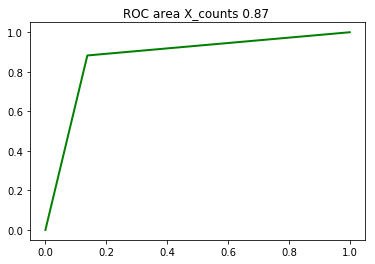

ROC area X_binary  0.872394879648


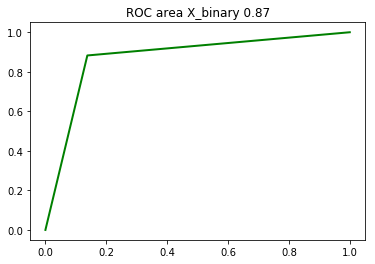

ROC area X_tfidf_estimator  0.885418880816


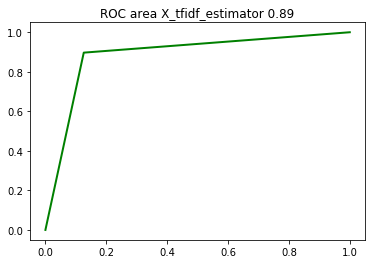

ROC area X_binary_imbalance_estimator  0.870090939476


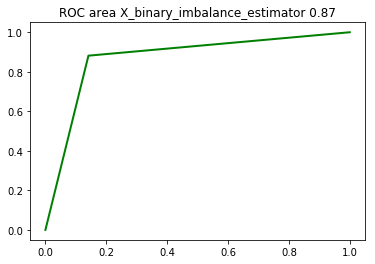

In [331]:
#plot ROC curve X_counts

predicted_train = X_counts_estimator.predict(XC_test)
fpr, tpr, thresholds = roc_curve(yC_test,predicted_train)
roc_auc = auc(fpr, tpr)
print ("ROC area X_counts ",roc_auc)
plt.title('ROC area X_counts %0.2f '%roc_auc)
plt.plot(fpr, tpr, color='g', lw=2)
plt.show()

#plot ROC curve

predicted_train = X_binary_estimator.predict(XB_test)
fpr, tpr, thresholds = roc_curve(yB_test,predicted_train)
roc_auc = auc(fpr, tpr)
print ("ROC area X_binary ", roc_auc)
plt.title('ROC area X_binary %0.2f'%roc_auc)
plt.plot(fpr, tpr, color='g', lw=2)
plt.show()

#plot ROC curve

predicted_train = X_tfidf_estimator.predict(XT_test)
fpr, tpr, thresholds = roc_curve(yT_test,predicted_train)
roc_auc = auc(fpr, tpr)
print ("ROC area X_tfidf_estimator ", roc_auc)
plt.title('ROC area X_tfidf_estimator %0.2f'%roc_auc)
plt.plot(fpr, tpr, color='g', lw=2)
plt.show()


#plot ROC curve

predicted_train = X_binary_imbalance_estimator.predict(XI_test)
fpr, tpr, thresholds = roc_curve(yI_test,predicted_train)
roc_auc = auc(fpr, tpr)
print ("ROC area X_binary_imbalance_estimator ", roc_auc)
plt.title('ROC area X_binary_imbalance_estimator %0.2f'%roc_auc)
plt.plot(fpr, tpr, color='g', lw=2)
plt.show()

Retrain the 4 classifiers using all the 100% train data

In [332]:
# Retrain the classifier on the whole data for X_counts
X_counts_estimator = LinearSVC(C=X_counts_C, random_state=0).fit(X_counts,np.array(train['sentiment']))

# Retrain the classifier on the whole data for X_binary
X_binary_estimator = LinearSVC(C=X_binary_C, random_state=0).fit(X_binary,np.array(train['sentiment']))

# Retrain the X_tfidf classifier on the whole data for X_tfidf
X_tfidf_estimator = LinearSVC(C=X_tfidf_C, random_state=0).fit(X_tfidf,np.array(train['sentiment']))

# Retrain the classifier on the whole data for X_binary_imbalance_estimator
X_binary_imbalance_estimator = LinearSVC(C=X_binary_imbalance_C, random_state=0).fit(X_binary_imbalance,np.array(train_df_imbalance['sentiment']))
print ('retrained all classifiers over 100% data', time.ctime())

retrained all classifiers over 100% data Wed Feb  8 23:18:28 2017


The following block cleans the test data

In [333]:
# Test data set processing

# Create an empty list and append the clean reviews one by one
clean_test_reviews = []
for i in range(0,len(test["review"])):
    clean_test_reviews.append(" ".join(KaggleWord2VecUtility.review_to_wordlist(test["review"][i], True)))
print ("Cleaned the test set movie reviews.\n")

Cleaned the test set movie reviews.



Get a bag of words for the test set, and convert to a numpy array

In [334]:
test_X_counts = vectorizer.transform(clean_test_reviews)
test_X_counts = test_X_counts.toarray()

Calculate the binary and tdidf matrices from test_X_counts matrix

In [335]:
test_X_binary, test_X_tfidf, dummyA, dummyB, dummyC=calc_X_matrices(test_X_counts,None, True)

Make the matrices sparse

In [336]:
test_X_counts = csr_matrix(test_X_counts)
test_X_binary = csr_matrix(test_X_binary)
test_X_tfidf = csr_matrix(test_X_tfidf)

Make predictions about the test data

Function to make prediction for test data

In [337]:
def make_prediction(X,test_X, estimator, X_type):
    #X_type is for me to know which X matrix we are talking about
    #predict sentiment for test set-test_X
    predicted_test=estimator.predict(test_X)

    # Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
    output = pd.DataFrame( data={"id":test["id"], "sentiment":predicted_test} )

    # Use pandas to write the comma-separated output file
    output.to_csv('./Output_'+X_type+'.csv', index=False, quoting=3)
    print ("Wrote results to Output_"+X_type+".csv", time.ctime())

In [338]:
make_prediction(X_counts,test_X_counts,X_counts_estimator,"counts")
make_prediction(X_binary,test_X_binary,X_binary_estimator,"binary")
make_prediction(X_tfidf,test_X_tfidf,X_tfidf_estimator,"tfidf")

#test_X_binary_imbalance doesn't exist, using test_X_binary as input
make_prediction(X_binary_imbalance,test_X_binary,X_binary_imbalance_estimator,"binary_imbalance")
print ("Created the files")

Wrote results to Output_counts.csv Wed Feb  8 23:19:13 2017
Wrote results to Output_binary.csv Wed Feb  8 23:19:13 2017
Wrote results to Output_tfidf.csv Wed Feb  8 23:19:14 2017
Wrote results to Output_binary_imbalance.csv Wed Feb  8 23:19:14 2017
Created the files


The Kaggle score using the 4 different predictions generated are:
Counts matrix: 0.87296 
Binary matrix: 0.87296.
Tfidf matrix: 0.88068
Imbalance matrix: 0.86808

For Kaggle submissions the tdidf design matrix performed best

Function for Part 4, to plot the learning curve

In [339]:
def plot_learning_curve(X, y, train_sizes):

    #plt.figure()
    plt.title('Learning curve on X_counts')
    plt.xlabel("Number of Training examples")
    plt.ylabel("Score")
    estimator=LogisticRegression()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, color="b",label="Training score",lw=2)
    plt.plot(train_sizes, test_scores_mean, color="g",label="Cross-validation score",lw=2)
    plt.legend(loc="best")
    plt.show()

The following block plots the learning curve

part 4, plot the learning curve


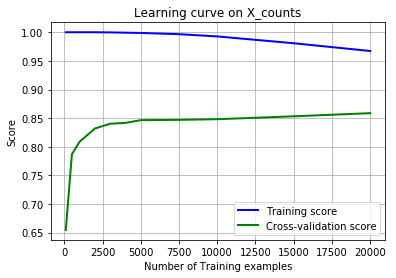

In [340]:
print ("part 4, plot the learning curve")
number_train = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]
plot_learning_curve(X_counts,np.array(train['sentiment']),number_train)